# Qblox basic sequencing

This tutorial outputs the same waveforms as in the [Basic Sequencing](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/baseband/basic_sequencing.html) tutorial, but using quantify instead.

Quantify allows a either a gate or pulse to be played from a qblox instrument. Gates are performed on qubits (see [Operations and Qubits](https://quantify-os.org/docs/quantify-scheduler/tutorials/Operations%20and%20Qubits.html)) and pulses are played on ports (see [Schedules and Pulses](https://quantify-os.org/docs/quantify-scheduler/tutorials/Schedules%20and%20Pulses.html)).

In this tutorial, we will play both gates and pulses.

First we set the data directory.

In [1]:
from __future__ import annotations

from qcodes.instrument import find_or_create_instrument

from quantify_core.data import handling as dh

dh.set_datadir()

Data will be saved in:
C:\Users\Daniel Weigand\quantify-data


## Connections

First, we define a quantum device with one transmon (qubit).

The transmon here is a device element (typically a type of qubit) and is only necessary when using a gate operation, since the same gate can be implemented differently on different types of device elements. Take for example the `Measure` operation. The state of a transmon is determined by measuring a signal sent to a resonator coupled to it, but the state of a spin qubit is determined by measuring a current.

In [2]:
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement

single_transmon_device = find_or_create_instrument(QuantumDevice, recreate=True, name="DUT")
transmon = find_or_create_instrument(BasicTransmonElement, recreate=True, name="transmon")
single_transmon_device.add_element(transmon)

We will assume the transmon is already calibrated, and that we know the frequency of the qubit and the parameters for a $\pi$-pulse. We can assign this known frequency and $\pi$-pulse parameters to the transmon.

In [3]:
transmon.clock_freqs.f01(5e9)  # The |0> <=> |1> transition frequency is at 5 GHz.
transmon.rxy.amp180(0.3)  # The amplitude of a pi pulse is 0.3

Next, we define the module(s) that are connected to the quantum device.

In this case, one Qblox Cluster with a QCM (or QRM) in slot 4.

We will use three outputs of the QCM for the tutorial to showcase both real and complex output signals. Please make appropriate modifications if using a QRM which only has two outputs.

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/api_reference/tools.html#api-pnp) for more info).

In [4]:
!qblox-pnp list

Devices:
 - 10.10.200.13 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QSE_1" and serial number 00015_2321_005
 - 10.10.200.42 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "QAE-I" and serial number 00015_2321_004
 - 10.10.200.43 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.2 with name "QAE-2" and serial number 00015_2206_003
 - 10.10.200.50 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2219_003
 - 10.10.200.53 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.7.0 with name "cluster-mm" and serial number 00015_2320_004
 - 10.10.200.70 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number 123-456-789
 - 10.10.200.80 via 192.168.207.146/24 (reconfiguration needed!): cluster_mm 0.6.1 with name "cluster-mm" and serial number not_valid


In [5]:
cluster_ip = "10.10.200.42"
cluster_name = "cluster0"

### Connect to Cluster

We now make a connection with the Cluster.

In [6]:

from qblox_instruments import Cluster, ClusterType

cluster = find_or_create_instrument(
    Cluster,
    recreate=True,
    name=cluster_name,
    identifier=cluster_ip,
    dummy_cfg=(
        {
            2: ClusterType.CLUSTER_QCM,
            4: ClusterType.CLUSTER_QRM,
            6: ClusterType.CLUSTER_QCM_RF,
            8: ClusterType.CLUSTER_QRM_RF,
        }
        if cluster_ip is None
        else None
    ),
)

#### Get connected modules

In [7]:
from typing import TYPE_CHECKING, Callable

if TYPE_CHECKING:
    from qblox_instruments.qcodes_drivers.module import QcmQrm


def get_connected_modules(cluster: Cluster, filter_fn: Callable | None = None) -> dict[int, QcmQrm]:
    def checked_filter_fn(mod: ClusterType) -> bool:
        if filter_fn is not None:
            return filter_fn(mod)
        return True

    return {
        mod.slot_idx: mod for mod in cluster.modules if mod.present() and checked_filter_fn(mod)
    }

In [8]:
# QRM baseband modules
modules = get_connected_modules(cluster, lambda mod: mod.is_qrm_type and not mod.is_rf_type)
modules

{4: <Module: cluster0_module4 of Cluster: cluster0>}

In [9]:
module = modules[4]

In [10]:
slot_no = module.slot_idx
if module.is_qcm_type:
    module_type = "QCM"
if module.is_qrm_type:
    module_type = "QRM"

Create a dummy Local Oscillator with the same name as in the hardware config. This can be replaced with a microwave generator in an actual situation

In [11]:
from quantify_scheduler.helpers.mock_instruments import MockLocalOscillator

lo1 = find_or_create_instrument(MockLocalOscillator, recreate=True, name="lo1")

Now we define the connections between the quantum device and the qblox instrument(s). For this we define a hardware config according to the [Qblox backend](https://quantify-os.org/docs/quantify-scheduler/latest/reference/qblox/index.html) tutorial.

In [12]:
hardware_config = {
    "backend": "quantify_scheduler.backends.qblox_backend.hardware_compile",  # Use the Qblox backend
    "cluster0": {  # The first instrument is named "cluster0"
        "instrument_type": "Cluster",  # The instrument is a Qblox Cluster
        "ref": "internal",  # Use the internal reference clock
        f"cluster0_module{slot_no}": {  # This is the module in slot <slot_no> of the cluster. (slot 0 has the CMM)
            "instrument_type": f"{module_type}",  # The module is either a QCM or QRM module
            "complex_output_0": {  # The module will output a real signal from output 0 (O1)
                "lo_name": "lo1",  # output 0 and 1 (O1 and O2) are connected to the I and Q ports of an IQ mixer with a LocalOscillator by the name lo1
                "portclock_configs": [  # Each output can contain upto 6 portclocks. We will use only one for this tutorial
                    {
                        "port": "transmon:mw",  # This output is connected to the microwave line of qubit 0
                        "clock": "transmon.01",  # This clock tracks the |0> <=> |1> transition of the transmon
                    },
                ],
            },
        },
    },
    "lo1": {
        "instrument_type": "LocalOscillator",
        "frequency": 4.9e9,
        "power": 20,
    },  # lo1 has a frequency of 4.9 GHz and is set to a power level of 20 (can be dBm)
}

In [13]:
if module_type == "QCM":
    hardware_config["cluster0"][f"cluster0_module{slot_no}"]["real_output_2"] = (
        {  # The QCM will output a real signal from output 2
            "portclock_configs": [
                {
                    "port": "transmon:fl",  # This output is connected to the flux line of qubit 2
                    "clock": "cl0.baseband",  # This default value (clock with zero frequency) is used if a clock is not provided.
                },
            ]
        },
    )

In [14]:
single_transmon_device.hardware_config(hardware_config)

## Schedule

We can now create a `Schedule` of pulses or gates to play.

In [15]:
from quantify_scheduler import Schedule

sched = Schedule(
    "Basic sequencing", repetitions=2**27
)  # The schedule will be played repeatedly 2^27 times

Let's create the control portion of an experiment.

First we specify an arbitrary numerical pulse to be played on the microwave port of the transmon.

Here we play a gaussian pulse constructed from the scipy library.

In [16]:
import numpy as np
from scipy.signal import gaussian

from quantify_scheduler.operations.pulse_library import NumericalPulse

t = np.arange(0, 48.5e-9, 1e-9)

gaussian_pulse = sched.add(
    NumericalPulse(
        samples=0.2 * gaussian(len(t), std=0.12 * len(t))
        - 1j * gaussian(len(t), std=0.12 * len(t)),  # Numerical pulses can be complex as well.
        t_samples=t,
        port="transmon:mw",
        clock="transmon.01",
    ),
    ref_pt="start",
    rel_time=0e-9,
)

Next, we apply a square pulse to the flux port of the transmon at the same time as the Gaussian Pulse

In [17]:
from quantify_scheduler.operations.pulse_library import SquarePulse

if module_type == "QCM":
    square_pulse = sched.add(
        SquarePulse(amp=0.4, duration=32e-9, port="transmon:fl", clock="cl0.baseband"),
        ref_pt="start",  # Play at the start of
        ref_op=gaussian_pulse,  # the gaussian pulse
        rel_time=0e-9,  # Delay the pulse by 0 ns
    )

Finally, we apply an X gate to the transmon. This uses the stored parameters in the `transmon` object.

In [18]:
from quantify_scheduler.operations.gate_library import X
from quantify_scheduler.resources import ClockResource

pi_pulse = sched.add(X(qubit=transmon.name), ref_op=gaussian_pulse)

sched.add_resource(
    ClockResource(name="transmon.01", freq=transmon.clock_freqs.f01())
)  # A ClockResource is necessary for the schedule to know the frequency of the transmon.

## Compilation

We then compile the schedule to produce instructions for the instruments.

We use the `SerialCompiler` here, which first converts all gates to pulses, then all pulses to instrument instructions.

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Basic sequencing'}, xlabel='Time [ns]', ylabel='Amplitude [V]'>)

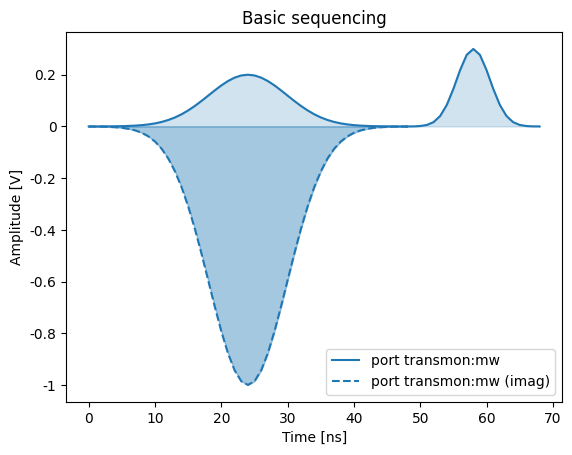

In [19]:
from quantify_scheduler.backends.graph_compilation import SerialCompiler

compiler = SerialCompiler(name="compiler")
compiled_sched = compiler.compile(
    schedule=sched, config=single_transmon_device.generate_compilation_config()
)

compiled_sched.plot_pulse_diagram()

We can view the compiled sequencer instructions sent to the QCM module. This may be compared to the program in the [Basic Sequencing](https://qblox-qblox-instruments.readthedocs-hosted.com/en/main/tutorials/q1asm_tutorials/basic/baseband/basic_sequencing.html) tutorial. Notice the extra instructions here that set the gain for each waveform played and the automatically calculated wait times.

In [20]:
print(
    compiled_sched.compiled_instructions["cluster0"][f"cluster0_module{slot_no}"]["sequencers"][
        "seq0"
    ]["sequence"]["program"]
)

 set_mrk 0 # set markers to 0
 wait_sync 4 
 upd_param 4 
 wait 4 # latency correction of 4 + 0 ns
 move 134217728,R0 # iterator for loop with label start
start:   
 reset_ph  
 upd_param 4 
 set_awg_gain 6554,-32768 # setting gain for NumericalPulse
 play 0,0,4 # play NumericalPulse (48 ns)
 wait 44 # auto generated wait (44 ns)
 set_awg_gain 9821,0 # setting gain for X transmon
 play 1,1,4 # play X transmon (20 ns)
 wait 16 # auto generated wait (16 ns)
 loop R0,@start 
 stop  



## Instrument coordinator

We create and instrument coordinator to prepare and run the schedule

In [21]:
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent

instrument_coordinator = find_or_create_instrument(
    InstrumentCoordinator, recreate=True, name="instrument_coordinator"
)
instrument_coordinator.add_component(ClusterComponent(cluster))

In [22]:
# Set the qcodes parameters and upload the schedule program
instrument_coordinator.prepare(compiled_sched)

We can now start the playback of the schedule. If you wish to view the signals on an oscilloscope, you can make the necessary connections and set up the oscilloscope accordingly.

In [23]:
# Start the hardware execution
instrument_coordinator.start()

In [24]:
instrument_coordinator.stop()